In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 38.0 MB/s eta 0:00:00


In [4]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from datasets import load_dataset, DatasetDict

# Load dataset
ds = load_dataset("Jiwonny29/elementalhero")

# Organize into a single DatasetDict
ds = DatasetDict({
    'train': ds['train'],
    'test': ds['test']
})

Generating train split:   0%|          | 0/114 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

In [6]:
ds['train']

Dataset({
    features: ['image', 'id', 'name', 'type', 'desc', 'atk', 'def', 'level', 'race', 'attribute', 'archetype', 'image_url', 'image_path', 'simplified_type'],
    num_rows: 114
})

In [7]:
ds['test']

Dataset({
    features: ['image', 'id', 'name', 'type', 'desc', 'atk', 'def', 'level', 'race', 'attribute', 'archetype', 'image_url', 'image_path', 'simplified_type'],
    num_rows: 29
})

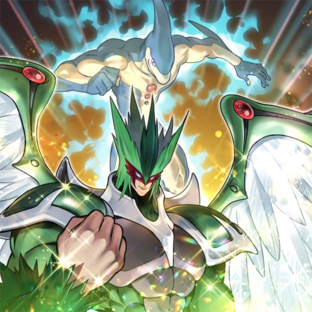

In [8]:
example = ds['train'][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

In [9]:
example["desc"]

'Shuffle 1 "Elemental HERO" or "Neo-Spacian" monster you control into the Deck, and if you do, Special Summon 1 "Elemental HERO" or "Neo-Spacian" monster with a different name from your Deck. You can banish this card from your GY; shuffle from your GY into the Deck, either 1 "Elemental HERO" monster and 1 "Neo-Spacian" monster, OR 1 "Elemental HERO Neos", then draw 1 card. You can only use each effect of "EN Shuffle" once per turn.'

In [10]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["desc"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # Generate attention mask
        attention_mask = encoding["input_ids"].clone()
        attention_mask[attention_mask != self.processor.tokenizer.pad_token_id] = 1

        encoding["attention_mask"] = attention_mask

        return encoding

In [11]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
train_dataset = ImageCaptioningDataset(ds['train'], processor)

In [13]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [16]:
processor.decode(batch["input_ids"][0])

'[CLS] during each of your end phases : inflict 200 damage to your opponent for each face - up " elemental hero " monster you control. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
import numpy as np
from PIL import Image

# Load an image. For example, specify the image file path in 'image_path'.
image = Image.open('/content/drive/MyDrive/213326.jpg')

# Convert the image to a numpy array.
image_array = np.array(image)

# Calculate the mean and standard deviation for each channel of the image.
mean = np.mean(image_array, axis=(0, 1))
std = np.std(image_array, axis=(0, 1))

print("Mean:", mean)
print("Std:", std)

Mean: [152.65617552  99.48618559  49.95973044]
Std: [79.87762027 60.99149622 51.37972661]


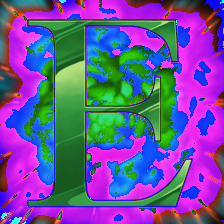

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([152.65617552, 99.48618559, 49.95973044]) / 255
STD = np.array([79.87762027, 60.99149622, 51.37972661]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [17]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [18]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.6390, grad_fn=<NllLossBackward0>)

In [19]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Loss: 11.453603744506836


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 10.575636863708496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.779866218566895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.328272819519043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.973153114318848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.823127746582031


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.509001731872559


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.254348754882812


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.979100227355957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.765594959259033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.4304986000061035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.462581157684326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.027824401855469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.914183616638184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.738850116729736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.717931270599365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.707418918609619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.284626007080078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.034028053283691


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.941859722137451


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.701573848724365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.65517520904541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.485445976257324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.2926435470581055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.95418643951416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.829748153686523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.644425392150879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.465147972106934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.239517688751221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.12475061416626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.8962249755859375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.6859092712402344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.445924997329712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.2596662044525146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.041714906692505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.0350286960601807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.6732425689697266


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.5777299404144287


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.3946893215179443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.1894054412841797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.1313037872314453


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.7682199478149414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.6957634687423706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.5847784280776978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.4096806049346924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.2261481285095215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.2718085050582886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.1047817468643188


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.9725872278213501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8239744305610657


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8476940989494324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6945783495903015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8331226110458374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5722265243530273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5121216773986816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.594601035118103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7868409156799316
Epoch: 1


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3688321113586426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.539196252822876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3665337860584259


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5713629722595215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5933626294136047


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27146413922309875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.31263720989227295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5748298168182373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5713216662406921


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6015223860740662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.34524497389793396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23586779832839966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19138941168785095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5329517126083374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4667710065841675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3260165750980377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4987604022026062


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2748163044452667


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5060428380966187


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5559810400009155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5050046443939209


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5388574004173279


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2995467185974121


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.32365792989730835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2623278498649597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35537633299827576


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22905626893043518


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.49952518939971924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6114676594734192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.32959064841270447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5092848539352417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4764077961444855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23549596965312958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4143293797969818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.725778341293335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5271384119987488


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2990015149116516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2376563549041748


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3682742416858673


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27880775928497314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21002650260925293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23227369785308838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16764308512210846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24524913728237152


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.42592525482177734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2890479266643524


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4138317108154297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4016580879688263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1916484534740448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27200132608413696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.41678208112716675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5316652655601501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3519352972507477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5164436101913452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36892521381378174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22014673054218292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.30127087235450745
Epoch: 2


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3660898208618164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0651383176445961


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.30797597765922546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2998788356781006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11457998305559158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18340963125228882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3809850811958313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4557088315486908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3164140582084656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09229210764169693


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17127902805805206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3498228192329407


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19443738460540771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3929387927055359


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19014500081539154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28864479064941406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15466490387916565


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.32727891206741333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3735296130180359


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.34097597002983093


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2458985596895218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.37962788343429565


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5159533023834229


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3893468976020813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.225553959608078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2925693690776825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3671073615550995


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4281156361103058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36243146657943726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18221792578697205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20851629972457886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20850004255771637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13645480573177338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.33798280358314514


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20812034606933594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19734254479408264


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.38942959904670715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4279889464378357


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14948834478855133


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.34218770265579224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.37801167368888855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1736275553703308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1680590808391571


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09576848894357681


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09398952126502991


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18913814425468445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23376283049583435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18339625000953674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35635948181152344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.39880692958831787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2705702781677246


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3480839431285858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2103957235813141


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27681782841682434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3809856176376343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27584996819496155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06965447962284088
Epoch: 3


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19647753238677979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2801220715045929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13014473021030426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12823328375816345


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12816299498081207


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3971157371997833


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24084968864917755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12229549884796143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1592015027999878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13443656265735626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25048592686653137


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20656754076480865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4244920015335083


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22168931365013123


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1652843952178955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2819630205631256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2509825825691223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15218517184257507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26281681656837463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24438995122909546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10441142320632935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08682418614625931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04699898138642311


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1570013016462326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2498311996459961


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15378466248512268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4128342270851135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17546358704566956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22097687423229218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13135145604610443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2664420008659363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1603454351425171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1561625599861145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08369775861501694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06612220406532288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.29028159379959106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11206594854593277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17669570446014404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2446112185716629


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.34645041823387146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4257994592189789


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13864003121852875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12653963267803192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09621106833219528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1334449201822281


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23919786512851715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.41068100929260254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06819317489862442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13518500328063965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06859177350997925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.457133948802948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.39120930433273315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2764560878276825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18970179557800293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2627885937690735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2630710005760193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24174243211746216
Epoch: 4


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16794425249099731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1446240246295929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17563210427761078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25131678581237793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1685033142566681


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15223003923892975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05472204089164734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2907841205596924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11931616812944412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21333470940589905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1303965449333191


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0845714583992958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22339369356632233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10558397322893143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11398953199386597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10236723721027374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11402711272239685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059067901223897934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.226339191198349


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2531697452068329


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0955558642745018


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13003723323345184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1562751829624176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06720411777496338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2225857526063919


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21778322756290436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.247150719165802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2781926691532135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18130038678646088


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13274434208869934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08419620245695114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15072230994701385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1890903264284134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05270351096987724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09927933663129807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2657500207424164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21442589163780212


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2103271782398224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17349834740161896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2908532917499542


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11472723633050919


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08165326714515686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2264198511838913


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13328120112419128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0849376693367958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1115235686302185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2313668131828308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10339110344648361


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19350166618824005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20766374468803406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.29737985134124756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1857638657093048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07609853148460388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16338279843330383


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14933478832244873


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12682019174098969


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06258635222911835
Epoch: 5


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07263395935297012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06631359457969666


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036166440695524216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15014146268367767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3144700527191162


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12903843820095062


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1600312888622284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08268789947032928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05836169421672821


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1108703687787056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1299089789390564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1400296539068222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1341019719839096


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17627570033073425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10034828633069992


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10253945738077164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06478609144687653


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15453238785266876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13667258620262146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1265866756439209


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1558859497308731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09952299296855927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1988087296485901


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0662955716252327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13410426676273346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1789751946926117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15641440451145172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08088325709104538


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1234973669052124


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15523944795131683


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09726826846599579


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0797884613275528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08246847242116928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08098794519901276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2594996690750122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14442326128482819


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16647711396217346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16291317343711853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06617999821901321


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09943465888500214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15676572918891907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051157377660274506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17805708944797516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1302824169397354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24897414445877075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14408689737319946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1019437313079834


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18615242838859558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08566230535507202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09866270422935486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14747527241706848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.057956770062446594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1787721961736679


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17629240453243256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11576114594936371


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1206294521689415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14370980858802795
Epoch: 6


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1202419176697731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1249997541308403


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08685366064310074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10482411086559296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06581185758113861


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.052749644964933395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10115054249763489


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08533181250095367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10772375762462616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12719672918319702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06953176856040955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19640959799289703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05870536342263222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09755753725767136


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07060132920742035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08411382883787155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03708949685096741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05772047117352486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033956509083509445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05374400317668915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09037929028272629


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15498597919940948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06194620579481125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19511860609054565


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05513320118188858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07249968498945236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05571712553501129


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07834238559007645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15226683020591736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19338010251522064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1064884290099144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23015469312667847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06574860215187073


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041232746094465256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1276090294122696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11221447587013245


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10273410379886627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1483975499868393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13492533564567566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17590473592281342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.050480280071496964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051699183881282806


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09202110767364502


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10911424458026886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039440128952264786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1130450889468193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1183776780962944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18341726064682007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14013072848320007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07327690720558167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07839876413345337


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09463664144277573


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0809817686676979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1659979224205017


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1268642097711563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1323672980070114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06173024699091911
Epoch: 7


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09817913919687271


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17895957827568054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04549725726246834


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05593453347682953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14608211815357208


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033372361212968826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055506832897663116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12410954385995865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04524911195039749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05799642577767372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05814691632986069


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06111185625195503


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11193175613880157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08488515764474869


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08917822688817978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061117980629205704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09130626171827316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10826438665390015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051637157797813416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020309552550315857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08928165584802628


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10890410840511322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06402991712093353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16793908178806305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13490942120552063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06773974746465683


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0779859721660614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10477466136217117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061721932142972946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07501085847616196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07757110148668289


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15575546026229858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05362167954444885


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07766291499137878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03732575848698616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0411229282617569


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05495233088731766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16360627114772797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07775022089481354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08023793250322342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07064290344715118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.054890163242816925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058434054255485535


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07389572262763977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047565702348947525


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019260354340076447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08517250418663025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039098501205444336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045496392995119095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05334404483437538


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06754391640424728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0690910816192627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07284710556268692


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0868121087551117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14460442960262299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10816320031881332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038144733756780624
Epoch: 8


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0727413222193718


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05043141171336174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0664452612400055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07113409042358398


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05040508881211281


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035247281193733215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02024175226688385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051265113055706024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041811030358076096


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04114064946770668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028378834947943687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05096783488988876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024325814098119736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06271433085203171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.049117561429739


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045898858457803726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044169824570417404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03283834829926491


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051817312836647034


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03445041552186012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025618424639105797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06498444825410843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041247062385082245


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07489445805549622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0961318165063858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08445259183645248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027532679960131645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0809050127863884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09609947353601456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0815807580947876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04158668965101242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07296785712242126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08815481513738632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04554556682705879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06152411177754402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05650269240140915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03986359015107155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05273326858878136


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08952229470014572


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055499617010354996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08375272899866104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06433521211147308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07116740942001343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07377872616052628


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08302479237318039


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.053258296102285385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0879376232624054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0877707377076149


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1226949617266655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05257556214928627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0486440472304821


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08169136196374893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0890117883682251


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05636191368103027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0709979310631752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029239462688565254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08857118338346481
Epoch: 9


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.052921660244464874


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033815063536167145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040755946189165115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02010633610188961


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07052376866340637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03565792739391327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06308651715517044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06237266957759857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07398880273103714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06076916679739952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043445222079753876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03934990614652634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06150444597005844


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02631882205605507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0689808651804924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06791775673627853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06679520756006241


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041646506637334824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05563946068286896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03624607250094414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044660475105047226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05699712410569191


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06966368854045868


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0499282106757164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036861639469861984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04448601230978966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02675609663128853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034446313977241516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0963117703795433


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059719741344451904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06453633308410645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04463408514857292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.048502709716558456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032903097569942474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04939180612564087


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06844887882471085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05209385231137276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05664508789777756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06888464093208313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05595463514328003


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03600561246275902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09340748935937881


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.060629747807979584


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04102103412151337


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07283000648021698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016057126224040985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05075164884328842


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06933557242155075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033434513956308365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06474320590496063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07998660206794739


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04442714527249336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03862538933753967


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03324318677186966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05722270533442497


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.049057696014642715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031060608103871346
Epoch: 10


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06709203124046326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026265881955623627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04709211364388466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025338836014270782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05887976661324501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.050423022359609604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046530790627002716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03919364884495735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04839141294360161


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06826476752758026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05981132388114929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0780624970793724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01876666024327278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0322878435254097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025215022265911102


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03562091663479805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023151898756623268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04313662648200989


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03434141352772713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03298689424991608


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03350460156798363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04770471155643463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040097665041685104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04792133718729019


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030244901776313782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02269717864692211


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04958944767713547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04185045138001442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02716229297220707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034992750734090805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05501329526305199


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018059002235531807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03296317532658577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02208578959107399


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04904429242014885


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05351586267352104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04600229114294052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03181558474898338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01797346957027912


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03410828486084938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05998072773218155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06006305292248726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.048650458455085754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04495354741811752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05241239815950394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044402819126844406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04210718348622322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03118668682873249


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041805461049079895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02732677012681961


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04795214533805847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05458309128880501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044816140085458755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039765045046806335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028681395575404167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055330540984869


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04009351506829262
Epoch: 11


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04216669872403145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046164315193891525


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020919958129525185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03629382699728012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03382713720202446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02696879394352436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025823304429650307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035015854984521866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061566151678562164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04754447937011719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024404652416706085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03437208756804466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04886516183614731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03772757574915886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047010064125061035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038316529244184494


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04564547911286354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0329180583357811


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028315981850028038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013681722804903984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026180431246757507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03149819374084473


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043705254793167114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04292447119951248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04252224415540695


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031838104128837585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039396341890096664


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06483273953199387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02587537094950676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030825726687908173


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021858636289834976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027501190081238747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04968002066016197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02034839242696762


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04897615313529968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03524782508611679


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08121748268604279


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03181436285376549


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021238820627331734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042104095220565796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021683843806385994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04026515409350395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047349847853183746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02128678373992443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04307112097740173


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027166996151208878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05150230601429939


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019525563344359398


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04849046468734741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037998490035533905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05075714364647865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042466145008802414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.050634149461984634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03432208299636841


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046569157391786575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06862671673297882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051954783499240875
Epoch: 12


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026582570746541023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029602017253637314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026598477736115456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02391345612704754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026385096833109856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04205932468175888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032420650124549866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03204481303691864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05450139939785004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04340970888733864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02100488916039467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038772329688072205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03622887283563614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0316840223968029


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04083901643753052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03458430990576744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02927411161363125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035500045865774155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03501862287521362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04347505047917366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04469190165400505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03442705422639847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03821643069386482


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015171666629612446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02200661040842533


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019436893984675407


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024085931479930878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04394678398966789


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03722118213772774


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02074872888624668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022544287145137787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03102041222155094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05045942962169647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02641953155398369


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02954992465674877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028348466381430626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030178584158420563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03649284318089485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025969969108700752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04910596087574959


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03382560610771179


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02138342894613743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045237381011247635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025865588337183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019747521728277206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03351247310638428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03286336362361908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031054992228746414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0315847247838974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05986572802066803


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03312418982386589


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04172163084149361


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020529652014374733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028878631070256233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021029414609074593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03378908708691597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021579818800091743
Epoch: 13


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01904687099158764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022197483107447624


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018280599266290665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02587791532278061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026242686435580254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01915118098258972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029466282576322556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032541923224925995


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025961989536881447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03292657807469368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023369992151856422


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01834135502576828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019398653879761696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026724081486463547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021237878128886223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0388212613761425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02053479477763176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02336835488677025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02394610457122326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023573875427246094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024644888937473297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027063410729169846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03627777099609375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016886120662093163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04123524948954582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019586624577641487


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022982027381658554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032453034073114395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01779070496559143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0223042331635952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03486621379852295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030728278681635857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029671521857380867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028667587786912918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024836335331201553


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03458560258150101


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023774143308401108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022416336461901665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03098188154399395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02878495492041111


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03640874847769737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03728655353188515


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02398546412587166


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015433586202561855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028254475444555283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041997116059064865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040143609046936035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020541759207844734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037138693034648895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028059037402272224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02205725573003292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026166880503296852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029465455561876297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028265152126550674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04837967827916145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019879497587680817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0333867073059082
Epoch: 14


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024952230975031853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015644913539290428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024948762729763985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020556623116135597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019410911947488785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018987378105521202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03574260696768761


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02383529581129551


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.050886012613773346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028190093114972115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023941779509186745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03196226432919502


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019760942086577415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023439573124051094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03758041933178902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030291227623820305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02584182471036911


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031663794070482254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02746991440653801


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022777771577239037


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03973441943526268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02030174806714058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019187455996870995


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018931658938527107


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02388126216828823


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017983190715312958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03912792727351189


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02058395743370056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021754615008831024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043396662920713425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0228810403496027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037094052881002426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02629443258047104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018382085487246513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018671147525310516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019910557195544243


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04016900435090065


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034772828221321106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021978743374347687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026234427466988564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029185758903622627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020366104319691658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046743493527173996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016398243606090546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030931539833545685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016901152208447456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01832112856209278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021440211683511734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030026398599147797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03404621034860611


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021661993116140366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025022534653544426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030110152438282967


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025184549391269684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058030866086483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02421727031469345


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04992560297250748
Epoch: 15


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013764060102403164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015449333935976028


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025184515863656998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044269222766160965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017715632915496826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011757277883589268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0187042448669672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02201424539089203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03770344331860542


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027402913197875023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02824512869119644


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026561010628938675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019536472856998444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017381321638822556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021046139299869537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03430402651429176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05518193915486336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05625373497605324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020955225452780724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05295331031084061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024417849257588387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021243711933493614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01695629023015499


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020515602082014084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028390830382704735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029500998556613922


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019542817026376724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031165264546871185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0353563092648983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02870916947722435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025738559663295746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027548639103770256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018085839226841927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0363592691719532


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027428338304162025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025477370247244835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0206457506865263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023954831063747406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03101343847811222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022712543606758118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027886075899004936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0350031778216362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0233220886439085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028217175975441933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01550800260156393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02147758938372135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0351778045296669


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036105573177337646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02225649170577526


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01961016282439232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035541974008083344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03003494255244732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027555692940950394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030888108536601067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013431836850941181


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024896876886487007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020534368231892586
Epoch: 16


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030331235378980637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02161276340484619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028063548728823662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021712442860007286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013227246701717377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012228794395923615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026756590232253075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018708793446421623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033830635249614716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016731319949030876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014666485600173473


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023476719856262207


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015097214840352535


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01792534999549389


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0258947741240263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01835016906261444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016853684559464455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04147517681121826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02269824966788292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028133124113082886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021689116954803467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026670251041650772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012556557543575764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022324765101075172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016677886247634888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02242913283407688


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021497050300240517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026305904611945152


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025863606482744217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029260708019137383


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014994483441114426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02214781567454338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023134784772992134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025990452617406845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022440366446971893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025023721158504486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025276489555835724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03578006476163864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029513821005821228


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02697860635817051


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027269279584288597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025786416605114937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02566676400601864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03340863436460495


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028160199522972107


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03321575000882149


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02815188094973564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018413394689559937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013860936276614666


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025502333417534828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03887451812624931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0233291108161211


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018221039324998856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011830884963274002


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02129053696990013


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029510103166103363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021323714405298233
Epoch: 17


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01934279128909111


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014531167224049568


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017593687400221825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030051592737436295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026459822431206703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0351257249712944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012185607105493546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028830714523792267


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024198489263653755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017401020973920822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015547365881502628


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015525903552770615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012999698519706726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022504519671201706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01620972529053688


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02038627117872238


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019057953730225563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016548004001379013


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02192378230392933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02012733742594719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021351097151637077


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01914309710264206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03389601781964302


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01812666840851307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02803562581539154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023038817569613457


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016628626734018326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021136799827218056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019472263753414154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028886985033750534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042659956961870193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018487300723791122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031960248947143555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020940661430358887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024661563336849213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022827863693237305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03200150653719902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019098039716482162


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020155588164925575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022014640271663666


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018614351749420166


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018862422555685043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020022299140691757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025286445394158363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034264594316482544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02053615264594555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024759074673056602


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018220826983451843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02543877810239792


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019063541665673256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02101942151784897


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02678295411169529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01933460310101509


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020561326295137405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03037913702428341


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015578807331621647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03168332204222679
Epoch: 18


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0148590337485075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020687077194452286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018170291557908058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010048163123428822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02006886526942253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014538165181875229


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023668531328439713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022834887728095055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020791150629520416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011572752147912979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017304128035902977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024721089750528336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018150117248296738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021503999829292297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015031050890684128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02682594023644924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01961650513112545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018134310841560364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01800527051091194


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023362210020422935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023019269108772278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01418942678719759


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020847057923674583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017830193042755127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02288433536887169


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01745065115392208


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02586027979850769


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01895342767238617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01889493130147457


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011090939864516258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020577842369675636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017801083624362946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026119425892829895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023443395271897316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01526337955147028


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024581218138337135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031112942844629288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025225015357136726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020795509219169617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020820800215005875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01952958106994629


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018437381833791733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01661207713186741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030464820563793182


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02303156815469265


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022296180948615074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0318647064268589


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018081553280353546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021111994981765747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02726591005921364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02431202493607998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020624512806534767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016672570258378983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03157734498381615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026601677760481834


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019169948995113373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030268540605902672
Epoch: 19


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021620815619826317


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021005267277359962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01862461306154728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01377849280834198


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014064863324165344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01735583506524563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013158909976482391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009502224624156952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023019544780254364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015463479794561863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014417966827750206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0295553058385849


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018782859668135643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020460495725274086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012902529910206795


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015975138172507286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015284305438399315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02181672304868698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027566969394683838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016394853591918945


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011609572917222977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01972280442714691


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026055337861180305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035458359867334366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018597694113850594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018143024295568466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025036504492163658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02334957756102085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0196138434112072


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016627255827188492


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01740088127553463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01625593937933445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01548814494162798


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025248214602470398


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020782019942998886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020254265516996384


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01697581447660923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02119063213467598


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021015046164393425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011145264841616154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01459132693707943


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021777421236038208


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02328544296324253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025659995153546333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017086507752537727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018103737384080887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024227241054177284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01757362112402916


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033853717148303986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028253888711333275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019916929304599762


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021513041108846664


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027678482234477997


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01700425148010254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019376389682292938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017296219244599342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0296266321092844
Epoch: 20


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014513605274260044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013768811710178852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012893376871943474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019868595525622368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01853630132973194


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014532686211168766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012392288073897362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02130693942308426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013606344349682331


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017954332754015923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02051599696278572


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015904977917671204


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014999781735241413


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01412449311465025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01804308034479618


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024617791175842285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01459808275103569


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012729506008327007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015300611034035683


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02211608551442623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01818205416202545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011863402090966702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016280662268400192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017963044345378876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016954854130744934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014228417538106441


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023483891040086746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021792370826005936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014319567941129208


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024830101057887077


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01932256482541561


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019095970317721367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015663081780076027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015717212110757828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021086430177092552


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011256651021540165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02269805036485195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01401758473366499


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013114445842802525


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01630190759897232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031186668202280998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029342779889702797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03211022540926933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013161635026335716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019960962235927582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02242046222090721


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029246415942907333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01654212549328804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020628534257411957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027131056413054466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01972632296383381


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01706443354487419


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022805893793702126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020628705620765686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01673814095556736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01806729845702648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022825609892606735
Epoch: 21


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0197778157889843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015821119770407677


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013909501023590565


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02568679489195347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012519432231783867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04067062959074974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01531989499926567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01672186888754368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01650123856961727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022727759554982185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011246684938669205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019479401409626007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01632087305188179


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017948906868696213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01668693870306015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021643133834004402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028459036722779274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02812371961772442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01921100541949272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010735132731497288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014288073405623436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01468424778431654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02017640881240368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011215412057936192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01943018101155758


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021652083843946457


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024587498977780342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019213058054447174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0190094206482172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021919554099440575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016352524980902672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018273264169692993


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025570690631866455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02093914896249771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02033494971692562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02668612077832222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014487632550299168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02286524698138237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02264942228794098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01829271763563156


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01187665481120348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016867712140083313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021272186189889908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019492417573928833


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018263952806591988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02585308812558651


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014392160810530186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02489774115383625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017682978883385658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029856769368052483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0121774822473526


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018003899604082108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02236088737845421


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021546898409724236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015882883220911026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016946710646152496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023125940933823586
Epoch: 22


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01650163345038891


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01997556909918785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018304752185940742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009406045079231262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018011149019002914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017303330823779106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02047932893037796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01313339825719595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014128227718174458


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015275358222424984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013402773067355156


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015722695738077164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01423146016895771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01908242516219616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01820480450987816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015563176944851875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019202278926968575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014314120635390282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02179429866373539


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017687270417809486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012713310308754444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0215546153485775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014224778860807419


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01154723297804594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01484520360827446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013553759083151817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021716896444559097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01283323671668768


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016125697642564774


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01917695626616478


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011665225960314274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017531199380755424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021266421303153038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021494999527931213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018908683210611343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019871676340699196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023835569620132446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02082022652029991


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021290261298418045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029807783663272858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01414356380701065


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017630720511078835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017231281846761703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017540251836180687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017101813107728958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01633874513208866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01369212381541729


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012128553353250027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02042466215789318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015087312087416649


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020768269896507263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022497687488794327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014128472656011581


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01617138460278511


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01783793978393078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019704237580299377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01916535571217537
Epoch: 23


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013783488422632217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00997586827725172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016593364998698235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009014245122671127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01051968801766634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009465012699365616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014661204069852829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02086084708571434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018381604924798012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012572846375405788


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010760137811303139


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015530022792518139


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013981534168124199


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012850102968513966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011636611074209213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01531596202403307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011348471976816654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015489621087908745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017288334667682648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016302440315485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017027927562594414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012412862852215767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015415042638778687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016852984204888344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015217672102153301


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014807866886258125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01783415488898754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017179924994707108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01692971959710121


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015250831842422485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01371623482555151


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028844622895121574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01337070669978857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014315390959382057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01645895652472973


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014437945559620857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013377721421420574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011268822476267815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017674520611763


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015888309106230736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019538922235369682


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013905150815844536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01559157483279705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020237160846590996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025478536263108253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020090121775865555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023581484332680702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014027765020728111


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015384762547910213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01149443257600069


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016318628564476967


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026674069464206696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014989104121923447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009905815124511719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01872556284070015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017558498308062553


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015266894362866879
Epoch: 24


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0108383409678936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008825477212667465


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01146763563156128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022376781329512596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012820448726415634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016583679243922234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015614116564393044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011777295731008053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029977302998304367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016919121146202087


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01597251556813717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012090117670595646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016312099993228912


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015488970093429089


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012118852697312832


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02050720527768135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013872380368411541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012604935094714165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025828909128904343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01617221161723137


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011764953844249249


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023873401805758476


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013632958754897118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01774119958281517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016384733840823174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017644189298152924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013644859194755554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017389005050063133


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012053796090185642


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016774088144302368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021558180451393127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018674258142709732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018669819459319115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01524165365844965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015085729770362377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014424785040318966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012674153782427311


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01276665460318327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019084526225924492


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016420455649495125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018862824887037277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018916524946689606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013157017529010773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017650559544563293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014543133787810802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01576494425535202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021146371960639954


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01955127902328968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012933846563100815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021810928359627724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012316929176449776


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013055124320089817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011838871985673904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01816534996032715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02037617191672325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02141784317791462


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027418548241257668
Epoch: 25


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014330828562378883


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03465012088418007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01392381638288498


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01279222872108221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012749051675200462


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01628037914633751


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01551807951182127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010085420683026314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012822622433304787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01545264758169651


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012388872914016247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014112875796854496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01400938630104065


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017154118046164513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025981074199080467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010363026522099972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013938000425696373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01924980618059635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01796330139040947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012765687890350819


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017372995615005493


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019112221896648407


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013679305091500282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014442040584981441


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012925714254379272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010704182088375092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015726612880825996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016258537769317627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014206389896571636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014593726024031639


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013111537322402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018675271421670914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020007288083434105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023603640496730804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013927685096859932


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018006330356001854


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012261267751455307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014199601486325264


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016310956329107285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021042922511696815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015071718022227287


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01709548756480217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016614913940429688


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020923860371112823


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01431298442184925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02123800478875637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010251965373754501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016228532418608665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016642577946186066


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01688401959836483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013289087451994419


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013388420455157757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018654031679034233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02593378722667694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015337423421442509


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01677739806473255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020682359114289284
Epoch: 26


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014955207705497742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01684795320034027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014368533156812191


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008782809600234032


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018267063423991203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013775985687971115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011212759651243687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02451767399907112


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00866943970322609


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014373249374330044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01840662956237793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009861701168119907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008889026939868927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008141561411321163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012708412483334541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010061378590762615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014538208022713661


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020311305299401283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017145680263638496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020617369562387466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021783730015158653


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02338976040482521


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013920613564550877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01175950188189745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01724131591618061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01812474988400936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020751599222421646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014428057707846165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013378703966736794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01407308503985405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027557648718357086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01363434735685587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01368022058159113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012604355812072754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01383452769368887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018321732059121132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019699929282069206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01215609721839428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013444445095956326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014107354916632175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014836795628070831


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019478406757116318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016629906371235847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01616218499839306


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014617152512073517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01667405292391777


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015139996074140072


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015449104830622673


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014020668342709541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01942220889031887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01682485267519951


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02143610268831253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015000224113464355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012049542739987373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017602473497390747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015938840806484222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013155495747923851
Epoch: 27


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011759476736187935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018789485096931458


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01183595322072506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011771277524530888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015590472146868706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014884800650179386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009855490177869797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0139069939032197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010713236406445503


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013130845502018929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016557127237319946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016902005299925804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011943507939577103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01143350824713707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01468950416892767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017384523525834084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014673835597932339


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012664099223911762


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015201643109321594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011020112782716751


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014749443158507347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03193596005439758


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01440480351448059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01953323371708393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010845988057553768


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018144506961107254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013298165053129196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014102346263825893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013649797067046165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017551610246300697


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016531404107809067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025424590334296227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023224283009767532


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017719518393278122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013471403159201145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01943681761622429


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021412283182144165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012782217934727669


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015585890039801598


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011315291747450829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01572227105498314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01315298117697239


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01566305197775364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013829318806529045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012546091340482235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01305800024420023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018538789823651314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01605626940727234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028759855777025223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01599149964749813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01631315052509308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018641769886016846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011406139470636845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027197256684303284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01456757914274931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0172259621322155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014308987185359001
Epoch: 28


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010109690949320793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0151072321459651


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011025320738554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01521428395062685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009927411563694477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013737316243350506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011605506762862206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011705134063959122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015651622787117958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013818972744047642


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012115905992686749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013297363184392452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01250382512807846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017658982425928116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01407293975353241


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015241927467286587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016087040305137634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01580914855003357


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018122972920536995


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012486126273870468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011144958436489105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013160220347344875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01143922470510006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01804317533969879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010035361163318157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021052636206150055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016202205792069435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015811363235116005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01289814617484808


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012859874404966831


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012672697193920612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008527013473212719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014033826999366283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012694238685071468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019465260207653046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017622336745262146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01875177212059498


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017601240426301956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013309493660926819


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019330602139234543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009968224912881851


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015398121438920498


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01244605053216219


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015031385235488415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017954327166080475


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01697687618434429


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015140640549361706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016499968245625496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011484655551612377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016906466335058212


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01352218259125948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012801377102732658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010972526855766773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014608942903578281


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017694467678666115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028520338237285614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014895823784172535
Epoch: 29


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014106317423284054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009253372438251972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01714472472667694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015510216355323792


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01527983509004116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02119748480618


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012755215167999268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008863979950547218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012527130544185638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011005263775587082


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008929261937737465


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01331285573542118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011235418729484081


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01400191430002451


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014898541383445263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015977410599589348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0192311629652977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016903158277273178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014022340066730976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009714977815747261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01021595299243927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012948375195264816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011907795444130898


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014666223898530006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011842570267617702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015575871802866459


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014776420779526234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012331652455031872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015696018934249878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014139029197394848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009419930167496204


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018424781039357185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0162424985319376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013469915837049484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011327965185046196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016587642952799797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01026610005646944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009177068248391151


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012346589006483555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014869577251374722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013240502215921879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011963693425059319


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012614000588655472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013529054820537567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015319282189011574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019437940791249275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02154369093477726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016978630796074867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018494825810194016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015030517242848873


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013391685672104359


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015102836303412914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014031716622412205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01131084281951189


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017201442271471024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020939376205205917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014419566839933395
Epoch: 30


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013145769014954567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011694164015352726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010911651886999607


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022438962012529373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01394594181329012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012263007462024689


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016632623970508575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012858377769589424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014353267848491669


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014118202030658722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011205194517970085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008714680559933186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009561079554259777


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009923438541591167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011866351589560509


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010787862353026867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0098256291821599


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023811563849449158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016830410808324814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017639251425862312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013601656071841717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017822759225964546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012296297587454319


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011865855194628239


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010048368014395237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012954252772033215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016575483605265617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015872115269303322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01547304168343544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013315667398273945


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010799677111208439


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011481967754662037


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015687542036175728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014157499186694622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016159042716026306


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017010269686579704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00897280965000391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012374857440590858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010877271182835102


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014743599109351635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015781396999955177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010032560676336288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009567439556121826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025056980550289154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011822120286524296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010672643780708313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01303430087864399


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01989496313035488


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014665991067886353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013109711930155754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01479591615498066


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017805006355047226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024074267596006393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014368523843586445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01463267020881176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01530085876584053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012767260894179344
Epoch: 31


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018447579815983772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007496420294046402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01700563170015812


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01034466177225113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01310531422495842


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010315956547856331


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014330768026411533


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013097994029521942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013514899648725986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01545871514827013


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009214846417307854


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013279437087476254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015436533838510513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012589803896844387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01177253108471632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01912347972393036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008563544601202011


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015084516257047653


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01571311429142952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011057120747864246


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013917108066380024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01195228099822998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009136688895523548


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017892610281705856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01927025057375431


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015246019698679447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012293731793761253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011326472274959087


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011434197425842285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017997844144701958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012600027024745941


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0072023142129182816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013830539770424366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012245687656104565


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017067208886146545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011005057953298092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012880544178187847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009931528009474277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012170768342912197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01287909597158432


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013416793197393417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014599104411900043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016371436417102814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013394723646342754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01431574672460556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015631839632987976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013247211463749409


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021433962509036064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02018410712480545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018308041617274284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011979983188211918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016709158197045326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016843298450112343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01831934228539467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016377894207835197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010725448839366436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015907902270555496
Epoch: 32


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013207451440393925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013135888613760471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009796747006475925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01603039912879467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009261065162718296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013290260918438435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015609269961714745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009294946677982807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011067680083215237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008513889275491238


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01178122591227293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014056033454835415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014353545382618904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012137237004935741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015953417867422104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010076324455440044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014349632896482944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011860768310725689


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011575855314731598


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011458257213234901


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013525962829589844


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013085807673633099


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01927996054291725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017023582011461258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01165615115314722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017564022913575172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019282737746834755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015999333932995796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01183424610644579


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016726449131965637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013985260389745235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0215736273676157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013238970190286636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011577918194234371


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013448732905089855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011945104226469994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012964933179318905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015047814697027206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0160521250218153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012696652673184872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018724681809544563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01303698681294918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011030229739844799


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012969199568033218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013708448968827724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0163898728787899


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01479101087898016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01788347214460373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020324578508734703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014821936376392841


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018327869474887848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014914793893694878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011829232797026634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010966725647449493


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00947064533829689


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014052817597985268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010962977074086666
Epoch: 33


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020582100376486778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009452907368540764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009726754389703274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013945801183581352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00972619466483593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009690448641777039


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018821874633431435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015345198102295399


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012238695286214352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014921639114618301


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011615985073149204


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012282033450901508


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009985142387449741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011425689794123173


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013479896821081638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009152081795036793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010172069072723389


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013256651349365711


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018781837075948715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020348595455288887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020026806741952896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015235158614814281


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008678124286234379


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011222651228308678


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015447045676410198


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010923066176474094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014221897348761559


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009777151048183441


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013601825572550297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018795263022184372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019199881702661514


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019703572615981102


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012532656081020832


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012617165222764015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015293845906853676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013591678813099861


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012861058115959167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016813870519399643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015214848332107067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014378163032233715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013563713990151882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013070468790829182


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01978902705013752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012610407546162605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013057087548077106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019253669306635857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01788404770195484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015531145967543125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013058289885520935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013470789417624474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023486383259296417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01208974327892065


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015940247103571892


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02093122899532318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0169537290930748


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025346675887703896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018615780398249626
Epoch: 34


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01350837480276823


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015560046769678593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009959639050066471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00876836758106947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0111257154494524


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025611620396375656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013138259761035442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007277375552803278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008155147545039654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04313584044575691


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017104675993323326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026382189244031906


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011898128315806389


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013333126902580261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011486545205116272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018648745492100716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01816065050661564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016419805586338043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012661284767091274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012755977921187878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02665424719452858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013222485780715942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026610426604747772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016349852085113525


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010326618328690529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011462993919849396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016241658478975296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014301588758826256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014362943358719349


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015725817531347275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019413180649280548


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011569606140255928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011963359080255032


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01394626870751381


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015409057028591633


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013072811998426914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018413564190268517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010533439926803112


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01887189783155918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01683853380382061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014909769408404827


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012236624956130981


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007763949688524008


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016789551824331284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01490691863000393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012141406536102295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017891010269522667


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023682380095124245


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013869615271687508


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012630284763872623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018148059025406837


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024974476546049118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013955352827906609


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016431311145424843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020210325717926025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015287818387150764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02633810229599476
Epoch: 35


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026165412738919258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010794682428240776


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012453228235244751


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013436512090265751


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010098188184201717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016424739733338356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01139239501208067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017646219581365585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00827586930245161


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018110206350684166


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011638827621936798


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014688118360936642


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022178176790475845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019971279427409172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009609728120267391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013369187712669373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01232698280364275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01991516724228859


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014524671249091625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012469087727367878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014100517146289349


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03999730944633484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01155675109475851


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014522966928780079


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011428304947912693


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013091878034174442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013870974071323872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013728841207921505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014116069301962852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01959949918091297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02041330374777317


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018204499036073685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010056083090603352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014965557493269444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011257467791438103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016920218244194984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017553793266415596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017838388681411743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017897119745612144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02252563089132309


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02967156283557415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01641169935464859


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029382910579442978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01044350303709507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01203053630888462


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01785825751721859


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014441300183534622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018237551674246788


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016000675037503242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018164917826652527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017594682052731514


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014604954048991203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0325341559946537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04754897952079773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014119735918939114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01712816022336483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010835584253072739
Epoch: 36


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014071405865252018


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015571937896311283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.057320207357406616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014386425726115704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014735936187207699


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017210980877280235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011994274333119392


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015781480818986893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021846110001206398


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018478184938430786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014214565046131611


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030700471252202988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01960885524749756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01826769858598709


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011931398883461952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026358587667346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013543307781219482


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02915799990296364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014067625626921654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017728906124830246


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01574522629380226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013965786434710026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01768782176077366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014973167330026627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009693103842437267


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01641608402132988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012080281972885132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02116132341325283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018052758648991585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022300830110907555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022683072835206985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02708800509572029


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02163030207157135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044139716774225235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01638653874397278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012412379495799541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013081165961921215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018169501796364784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014021472074091434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019510844722390175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02383144199848175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028889218345284462


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017272278666496277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03443632647395134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0110199935734272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01808789372444153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01118122786283493


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02762121707201004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022511882707476616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018799522891640663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014198124408721924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01619000732898712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012175069190561771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024308359250426292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019655443727970123


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016152076423168182


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026746423915028572
Epoch: 37


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016153398901224136


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037663184106349945


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010848777368664742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021479491144418716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025127537548542023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015723997727036476


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02333199977874756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010762094520032406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020149366930127144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020390786230564117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014297503978013992


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012177114374935627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01570657081902027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013389761559665203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013204247690737247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023500682786107063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018034204840660095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026978526264429092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020684299990534782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012888900004327297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026611698791384697


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025327017530798912


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015046375803649426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01805632747709751


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0118693383410573


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015009671449661255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014986325986683369


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024672647938132286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018163973465561867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01362826582044363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02908685989677906


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032878708094358444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037274543195962906


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016115251928567886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025955021381378174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022390233352780342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022676870226860046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017260482534766197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01622587814927101


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0170569010078907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016641009598970413


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030292343348264694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011232077144086361


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017991894856095314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016024556010961533


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016103126108646393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03014048933982849


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024088505655527115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034696705639362335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025261325761675835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01766778901219368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015842413529753685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01538858748972416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022989487275481224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011479150503873825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017445974051952362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01764477789402008
Epoch: 38


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010711469687521458


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02494175173342228


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017338717356324196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020040538161993027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010332579724490643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008148996159434319


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02445962280035019


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015068896114826202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010783588513731956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024427466094493866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02409607172012329


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026403987780213356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014763430692255497


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015334397554397583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030583659186959267


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012237383052706718


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03177995979785919


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025386620312929153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015814676880836487


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02677806280553341


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01583106815814972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05297921597957611


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02101583033800125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02038336917757988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03974185138940811


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020224299281835556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021194981411099434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024290069937705994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027075471356511116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01695716567337513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017880912870168686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014530004933476448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021418875083327293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015844253823161125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021159624680876732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016515132039785385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026997990906238556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029597872868180275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01968539133667946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01300226803869009


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014672030694782734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03218729421496391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025066325441002846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03039904683828354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031057273969054222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012478445656597614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014416075311601162


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030913451686501503


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017794998362660408


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01578153483569622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025663644075393677


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020152049139142036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016714993864297867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022742806002497673


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019524438306689262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01749814860522747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028256068006157875
Epoch: 39


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014410150237381458


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024082275107502937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012715106830000877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02906099148094654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015398873947560787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00963583029806614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021181834861636162


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019914500415325165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02925519086420536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023330816999077797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021048368886113167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012142275460064411


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010687514208257198


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04106516391038895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024800634011626244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020718075335025787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015278338454663754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02945748344063759


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02755989134311676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02493472956120968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014056749641895294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011173824779689312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013708187267184258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012946007773280144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01803041808307171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04153067618608475


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021894633769989014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035390909761190414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01572263054549694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02247912809252739


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02493940480053425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011647936888039112


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02965724468231201


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027353281155228615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013135298155248165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015995623543858528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0274531040340662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0167288389056921


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027546826750040054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019575675949454308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035833656787872314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01860124245285988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016166850924491882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019978825002908707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013029325753450394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019359279423952103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02253151684999466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02825567126274109


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032593511044979095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017543839290738106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03456063196063042


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014303247444331646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015872394666075706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030752377584576607


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021640004590153694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03786130249500275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03128155320882797
Epoch: 40


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015314063988626003


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02057950757443905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029802819713950157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016196513548493385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03498541936278343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020582206547260284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008143741637468338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02450934238731861


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0327240526676178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04926557466387749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012381196953356266


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038295309990644455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014363144524395466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020369520410895348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04026717692613602


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01594025269150734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013674379326403141


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028149008750915527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0320010669529438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022009508684277534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039011288434267044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041535429656505585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030151303857564926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04236682504415512


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024246342480182648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029902582988142967


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028301827609539032


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015444524586200714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028648052364587784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025271670892834663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021945448592305183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.056041426956653595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02531469613313675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03264302387833595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013650200329720974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038355570286512375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028573649004101753


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0249259602278471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03493286669254303


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045219648629426956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02305419370532036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0333891361951828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017464684322476387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01574600674211979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02539779432117939


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022544492036104202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013772653415799141


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04016866907477379


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04048721119761467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018845247104763985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030681179836392403


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027132811024785042


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047366488724946976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027407608926296234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029161490499973297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03957536444067955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02252267673611641
Epoch: 41


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020364070311188698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007716136518865824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038783520460128784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02099611982703209


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011296266689896584


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01721806265413761


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020588109269738197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.049155183136463165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013572579249739647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020201168954372406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010230226442217827


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034392453730106354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03126378357410431


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020804719999432564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028496142476797104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03139049559831619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0396297313272953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017751874402165413


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02344958484172821


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021773936226963997


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014401244930922985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028625888749957085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02246130257844925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022548163309693336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0285610631108284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025790229439735413


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035662028938531876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03052535094320774


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033088747411966324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03417199105024338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02616037428379059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0378323495388031


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04884401708841324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020874982699751854


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011322385631501675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01954803615808487


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022699642926454544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023600934073328972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019586671143770218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014163889922201633


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059795308858156204


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01767444983124733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014320646412670612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019655361771583557


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03536493703722954


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01830911450088024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03648308664560318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021051576361060143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02183963917195797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03482958301901817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021012213081121445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02739076502621174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01494020689278841


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02509613148868084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04184415191411972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014566529542207718


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025673571974039078
Epoch: 42


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021785806864500046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03572647646069527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011400383897125721


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016720948740839958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01554990466684103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00895374733954668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015133712440729141


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011155214160680771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02347056195139885


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018640311434864998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022166414186358452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015104825608432293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019521577283740044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013110633939504623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013535067439079285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01932314597070217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011598723009228706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03716394677758217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018007902428507805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02343251183629036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01601039245724678


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036843739449977875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016553495079278946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023374564945697784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022885192185640335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023314213380217552


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010685039684176445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0961611419916153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029613178223371506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017314670607447624


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01925487071275711


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01761569269001484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021022815257310867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013878210447728634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009277740493416786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01343273650854826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022146448493003845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021215999498963356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015741093084216118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013020339421927929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019947538152337074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03253577649593353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03480736166238785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012471954338252544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035650670528411865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011520100757479668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014881457202136517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015225759707391262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01712506078183651


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030784009024500847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011234248988330364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012246456928551197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015601808205246925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029639048501849174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010579179972410202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03062277100980282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030749613419175148
Epoch: 43


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012161076068878174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008976176381111145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010348284617066383


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03253863379359245


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01142434123903513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01965576782822609


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010448504239320755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01927858591079712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05034005269408226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02095058001577854


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016988219693303108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014894106425344944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01119652297347784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017024103552103043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019058384001255035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009567389264702797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01366910245269537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025194386020302773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015348316170275211


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014749756082892418


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013412781991064548


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015859462320804596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017125090584158897


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012277319096028805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02253628335893154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009609783068299294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012168070301413536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014269348233938217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014181671664118767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03160165622830391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013019425794482231


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01456406433135271


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01898939162492752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019525351002812386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03957004472613335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01391640491783619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016051510348916054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016490496695041656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009917126968502998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010950538329780102


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015475747175514698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012626033276319504


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016625797376036644


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013536470010876656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015953827649354935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015715667977929115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01751510240137577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03373899310827255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018051499500870705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013766219839453697


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019766584038734436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012666936963796616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02366853877902031


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020013077184557915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013341330923140049


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0163433738052845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02055894210934639
Epoch: 44


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010303976014256477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011245024390518665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03052602708339691


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012828852981328964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010027878917753696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010230008512735367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009205878712236881


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009362323209643364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01345273107290268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006604336202144623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013893036171793938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00814913585782051


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015022759325802326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01582907699048519


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02332014963030815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01580214872956276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01400744915008545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016448279842734337


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014833777211606503


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008122740313410759


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010705634020268917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015008701011538506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014021407812833786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015247270464897156


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012499863281846046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01724671758711338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012555732391774654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019173845648765564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007852247916162014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010455493815243244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02251678705215454


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013220393098890781


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016071908175945282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011566206812858582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02059122547507286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009901253506541252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014297151006758213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0157680232077837


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010503120720386505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01412662398070097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011879699304699898


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02676597237586975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02090630680322647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019121063873171806


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016905058175325394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010820257477462292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01751265674829483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031110329553484917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022326119244098663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020248962566256523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017434032633900642


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009371625259518623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010599476285278797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014590416103601456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014698963612318039


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02747376635670662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011527559719979763
Epoch: 45


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016987212002277374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016219723969697952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010994368232786655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013585145585238934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009775597602128983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011848373338580132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012399733066558838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013280601240694523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011803744360804558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011785328388214111


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008796460926532745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01613716594874859


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018494196236133575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010002046823501587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01711650937795639


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012187452986836433


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00757658900693059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009729508310556412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026744717732071877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012428396381437778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011369726620614529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014784441329538822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012214792892336845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01929524540901184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01809564046561718


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010886465199291706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010767673142254353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010778087191283703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014319056645035744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014513271860778332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01146489568054676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011607510969042778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015032704919576645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013766863383352757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011599021963775158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02064969576895237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016437536105513573


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021667340770363808


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022073931992053986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018369268625974655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017133744433522224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011596300639212132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013086141087114811


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011027336120605469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009301169775426388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01327044889330864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01503982674330473


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014896785840392113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01483848039060831


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010364455170929432


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005733574740588665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025263015180826187


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017957784235477448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01503706444054842


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023114440962672234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020013250410556793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02558683417737484
Epoch: 46


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01365133561193943


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010300970636308193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009493231773376465


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008279481902718544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02490086480975151


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009928100742399693


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00778799457475543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018081219866871834


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011948434635996819


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009872373193502426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009888127446174622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015822850167751312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012148875743150711


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016995972022414207


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009063638746738434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014181036502122879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010196364484727383


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012072734534740448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011916250921785831


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010051783174276352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009287793189287186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018957607448101044


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016820145770907402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010787051171064377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009865961968898773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010595746338367462


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01161409541964531


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009532511234283447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017424486577510834


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014537129551172256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017151128500699997


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010320843197405338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01587703451514244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017986640334129333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006957402918487787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02842322364449501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017590397968888283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009222463704645634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02414245903491974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012665134854614735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009959989227354527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01756308041512966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015466277487576008


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015949362888932228


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01064329780638218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016064267605543137


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016361061483621597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010232417844235897


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00995879527181387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011318986304104328


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01038718968629837


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011531154625117779


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013593744486570358


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009780598804354668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04908708110451698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015525451861321926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016675561666488647
Epoch: 47


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00854391697794199


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02435203082859516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00804322212934494


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010343719273805618


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008373930118978024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010666494257748127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011701319366693497


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010852869600057602


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027703622356057167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009636915288865566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013696645386517048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0223031435161829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012237212620675564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010696597397327423


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014204677194356918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008970621973276138


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026990298181772232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006818953901529312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014936380088329315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01688111573457718


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009123990312218666


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023287903517484665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01218386646360159


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012050420045852661


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011898846365511417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017437651753425598


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011297166347503662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01882452704012394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011271260678768158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01620347984135151


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01364038698375225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013883799314498901


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012408226728439331


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018121981993317604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030672941356897354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012204756028950214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015261680819094181


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018924476578831673


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014232587069272995


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01383249368518591


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021525591611862183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016878850758075714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017901528626680374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012460839934647083


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011416448280215263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010744653642177582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013259693048894405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010078173130750656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010095895268023014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014429663307964802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01660442352294922


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012676438316702843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011603012681007385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014989521354436874


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009332339279353619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012688838876783848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014402049593627453
Epoch: 48


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008814365603029728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016682492569088936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008103807456791401


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009477423503994942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010779967531561852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010191797278821468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014135726727545261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01121875923126936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009992514736950397


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010443870909512043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016399607062339783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012979784980416298


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009897181764245033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01591869629919529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010048341937363148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008982385508716106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00883469358086586


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011196562089025974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008427923545241356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009315104223787785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013154352083802223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014832991175353527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008325793780386448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01115448959171772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010378312319517136


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011965600773692131


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013876980170607567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008644310757517815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010660314001142979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012426579371094704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007101909257471561


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006840190384536982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014014261774718761


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008591112680733204


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011511002667248249


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011461155489087105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00771746039390564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012221228331327438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007780968211591244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009783850982785225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007236332632601261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009212381206452847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011503433808684349


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011758112348616123


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006437720265239477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017292575910687447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008214564993977547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011526759713888168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0160259660333395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014942734502255917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010170826688408852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01321737002581358


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01564454846084118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012285800650715828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011325392872095108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012144685722887516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009460137225687504
Epoch: 49


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008758440613746643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005761049687862396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008895362727344036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008518763817846775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008572912774980068


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007932934910058975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007021433673799038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010633420199155807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010662888176739216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020599843934178352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016665292903780937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010245569050312042


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013661233708262444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009917233139276505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012480801902711391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009484746493399143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016489021480083466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009549273177981377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009188607335090637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012463020160794258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012574085034430027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016786906868219376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013607329688966274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01379177626222372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012356763705611229


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014474478550255299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009505324997007847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013428803533315659


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01589714176952839


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011604148894548416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007090502884238958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011847843416035175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013343256898224354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008536520414054394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013859477825462818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009278399869799614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014337011612951756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011191955767571926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010525960475206375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013548197224736214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009099060669541359


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011271216906607151


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014130925759673119


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009442032314836979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015448199585080147


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009706581011414528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011874875985085964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020260874181985855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014602052979171276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009861293248832226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011008351109921932


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014469596557319164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010411637835204601


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011290301568806171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008702694438397884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00918203592300415
Loss: 0.014398099854588509


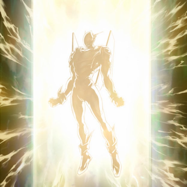

In [ ]:
# load image
example = ds['test'][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

when a spell / trap card is activated : banish 1 face - up " elemental hero " monster you control until the end phase ; negate the activation, and if you do, destroy that card. if you control " elemental hero terra firm


### Ground Truth Text
74095602.jpg

When an "Elemental HERO" Fusion Monster you control is destroyed by battle and sent to the Graveyard: Inflict damage to your opponent equal to its original Level x 300.

In [22]:
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')

# Prepare test data
test_dataset = ImageCaptioningDataset(ds['test'], processor)

# DataLoader for test data
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

# Generate captions for test data
generated_captions = []
ground_truth_captions = []

model.eval()
with torch.no_grad():
    for example in ds['test']:
        image = example["image"]
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        generated_captions.append(generated_caption)
        ground_truth_captions.append(example["desc"])

# Calculate BLEU score
bleu_score = corpus_bleu([[caption] for caption in ground_truth_captions], generated_captions)

print("BLEU Score:", bleu_score)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BLEU Score: 0.27448065363674334


In [21]:
model.save_pretrained("/content/drive/MyDrive")